In [1]:
import redis
import json
import requests
from bs4 import BeautifulSoup
import httpx
import time
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from sentence_transformers import SentenceTransformer
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import functional as F
from collections import defaultdict
from string import punctuation
from nltk.corpus import stopwords
from boilerpy3 import extractors
import spacy
from spacy.lang.en import English
from spacy.lang.ru import Russian
from nltk.corpus import wordnet as wn
from textblob import TextBlob
import tldextract
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from urllib.parse import urlparse
from nltk.classify import NaiveBayesClassifier
from nltk.classify.util import accuracy
import matplotlib.pyplot as plt
import datetime
import joblib
from collections import Counter

path = '/home/kalacheva/Desktop/'

import sys
sys.path.append(path + 'utils.py')
import utils
from utils import (remove_tld, print_results, predict_url, 
predict_label, check, symbol_ngrams, url_train_data, 
to_train_embeddings, remove_trash, to_token, classify_web)

import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [2]:
# Upload train and test datasets:

train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')

In [3]:
# Change url to get domain ('https://ya.ru/' -> 'ya.ru')

train_df['url'] = train_df['url'].apply(remove_tld)
test_df['url'] = test_df['url'].apply(remove_tld)

In [4]:
# Divide data for train/test columns and labels:

X_train, y_train = train_df['url'], train_df['category']
X_test, y_test = test_df['url'], test_df['category']

In [5]:
# # Example:

# vectorizer = CountVectorizer(ngram_range=(1, 2))  

# naive_bayes_classifier = MultinomialNB()

# model = make_pipeline(vectorizer, naive_bayes_classifier)
# model.fit(X_train[:100000], y_train[:100000])

# predicted_categories = model.predict(X_test)

# print(classification_report(y_test, predicted_categories))

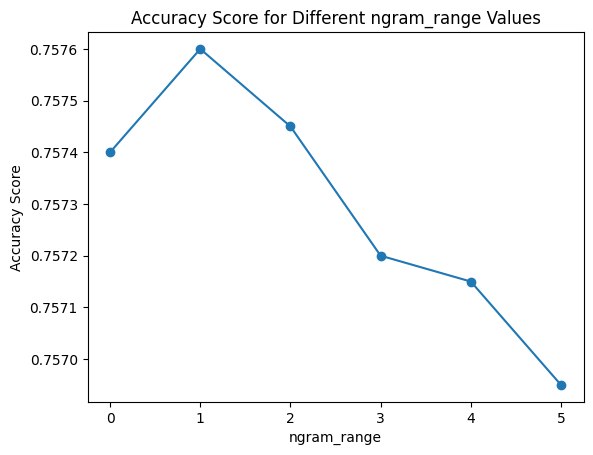

In [7]:
# We can plot score for each range and choose the best one:

ngram_ranges = [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7)]  

scores = []
ngram_values = []

for ngram_range in ngram_ranges:
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    naive_bayes_classifier = MultinomialNB()
    model = make_pipeline(vectorizer, naive_bayes_classifier)

    model.fit(X_train[:100000], y_train[:100000])
    predicted_categories = model.predict(X_test[:20000])
    score = accuracy_score(y_test[:20000], predicted_categories)

    scores.append(score)
    ngram_values.append(ngram_range)

plt.plot(range(6), scores, marker='o')

plt.xlabel('ngram_range')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score for Different ngram_range Values')
plt.show()

In [16]:
def train_and_save_model(category, train_df, test_df, save_path):
    
    print(f"Start training for {category} category")
    
    train_df_filtered = train_df[train_df['category'] == category]
    test_df_filtered = test_df[test_df['category'] == category]

    
    print(f'Filtering is done, len of train: {len(train_df_filtered)}, len of test: {len(test_df_filtered)}')
    
# #     If we don't want to wait for a long time
#     if len(train_df_filtered) > 80000:
#         train_df_filtered = train_df_filtered[:80000]
#     if len(test_df_filtered) > 20000:
#         test_df_filtered = test_df_filtered[:20000]
    
    
    train_df_not_category = train_df[train_df['category'] != category].sample(n=len(train_df_filtered))
    test_df_not_category = test_df[test_df['category'] != category].sample(n=len(test_df_filtered))
    
#     making labels:
    train_df_filtered.loc[:, 'category'] = f'{category}'
    test_df_filtered.loc[:, 'category'] = f'{category}'
    
    train_df_not_category.loc[:, 'category'] = f'not_{category}'
    test_df_not_category.loc[:, 'category'] = f'not_{category}'
    
#     full dataset:
    train_df_filtered = pd.concat([train_df_filtered, train_df_not_category], ignore_index=True)
    test_df_filtered = pd.concat([test_df_filtered, test_df_not_category], ignore_index=True)
    
#     mix for better score:
    train_df_filtered = train_df_filtered.sample(frac=1, random_state=42)
    test_df_filtered = test_df_filtered.sample(frac=1, random_state=42)
    
#     train_df_filtered.loc[:, 'url'] = train_df_filtered['url'].apply(remove_tld)
#     test_df_filtered.loc[:, 'url'] = test_df_filtered['url'].apply(remove_tld)

#     print('Domain is extracted.')

    X_train, y_train = train_df_filtered['url'], train_df_filtered['category']
    X_test, y_test = test_df_filtered['url'], test_df_filtered['category']
    
    ngram_ranges = [(1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7)]
    scores = []
    ngram_values = []

    best_score = 0
    best_ngram_range = None
    best_model = None
    
    print('Begin to check range values.')
    
    for ngram_range in ngram_ranges:
        vectorizer = CountVectorizer(ngram_range=ngram_range)
        naive_bayes_classifier = MultinomialNB()
        model = make_pipeline(vectorizer, naive_bayes_classifier)

        model.fit(X_train, y_train)
        predicted_categories = model.predict(X_test)
        score = accuracy_score(y_test, predicted_categories)

        if score > best_score:
            best_score = score
            best_ngram_range = ngram_range
            best_model = model

        scores.append(score)
        ngram_values.append(ngram_range)
        print(f'Checked {ngram_range}, result: {score}')

    print('Training best model.')
    
    vectorizer = CountVectorizer(ngram_range=best_ngram_range)
    naive_bayes_classifier = MultinomialNB()
    model = make_pipeline(vectorizer, naive_bayes_classifier)
    model.fit(X_train, y_train)

   
    joblib.dump(model, save_path + category + '.joblib')

    print(f'Best score: {best_score} with n-gram range: {best_ngram_range}')

In [17]:
categories = train_df.category.unique()

In [ ]:
for i in categories:
    train_and_save_model(i, train_df, test_df, path + 'ngram_models/')

Start training for Business and Industry category
Filtering is done, len of train: 2685746, len of test: 671855
Begin to check range values.
Checked (1, 2), result: 0.9016722358246944
Checked (1, 3), result: 0.9010277515237662
Checked (1, 4), result: 0.9005871802695522
Checked (1, 5), result: 0.9003028927372722
Checked (1, 6), result: 0.9001473532235378
Checked (1, 7), result: 0.8999888368770047
Training best model.
